<a href="https://colab.research.google.com/github/Nobel712/Deep-learning-project/blob/main/Brain_tumor_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 4.6 MB/s 


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


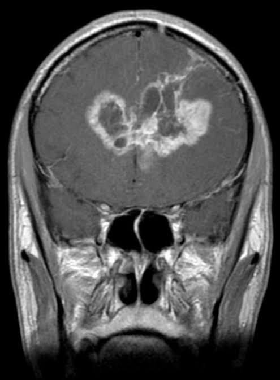

In [3]:
fill='/content/drive/MyDrive/Deep Db/Testing/glioma_tumor/image(1).jpg'
from tensorflow.keras.preprocessing import image
img=image.load_img(fill,target_size=(380,280))
img

In [7]:
def plot_images(direction):  
    list_direction=os.listdir(direction)

    plt.figure(figsize=(16,10))

    for i in range(1,10):
        plt.subplot(3,3,i)
        img=plt.imread(os.path.join(direction,list_direction[i]))
        plt.imshow(img,cmap='gray')
        plt.axis('off')
    plt.tight_layout()

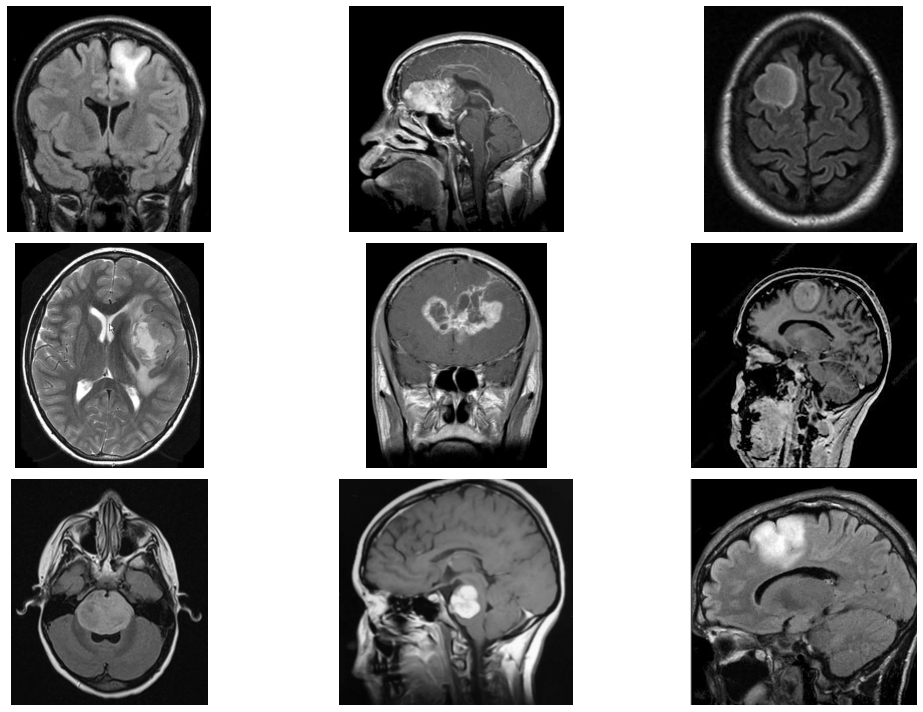

In [8]:
glioma_tumor_dir='/content/drive/MyDrive/Deep Db/Testing/glioma_tumor'
plot_images(glioma_tumor_dir)

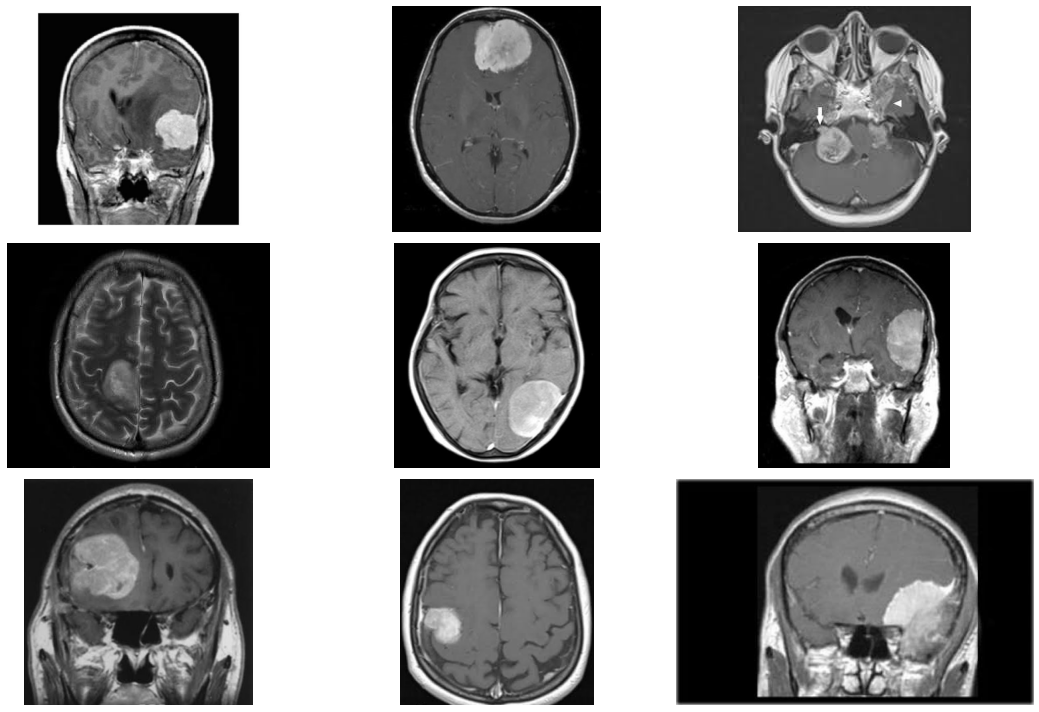

In [9]:
meningioma_tumor_dir='/content/drive/MyDrive/Deep Db/Testing/meningioma_tumor'
plot_images(meningioma_tumor_dir)

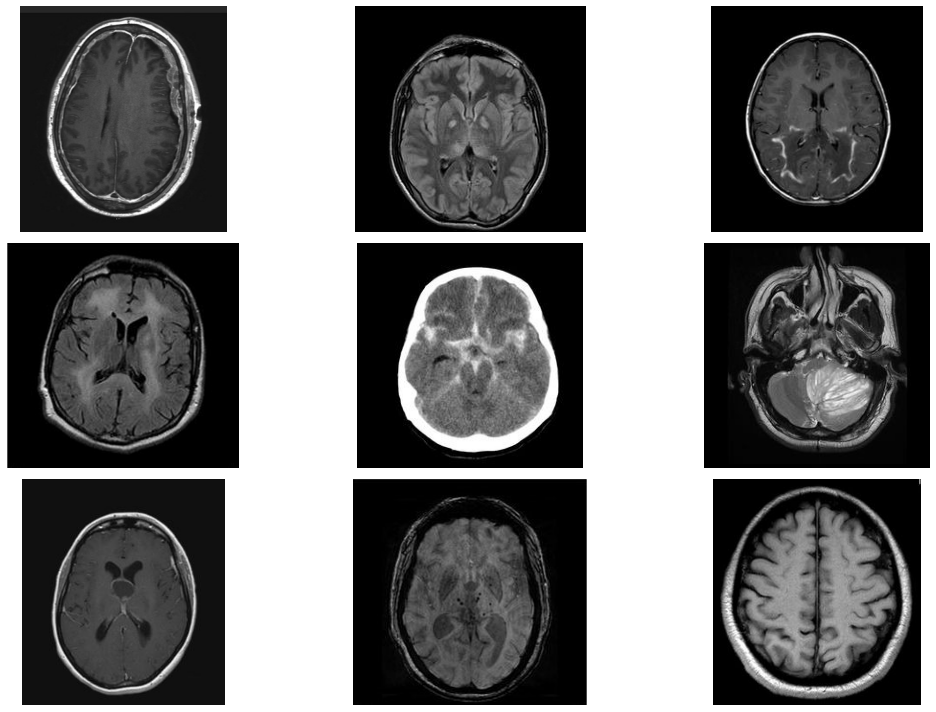

In [10]:
No_tumor_dir='/content/drive/MyDrive/Deep Db/Testing/no_tumor'
plot_images(No_tumor_dir)

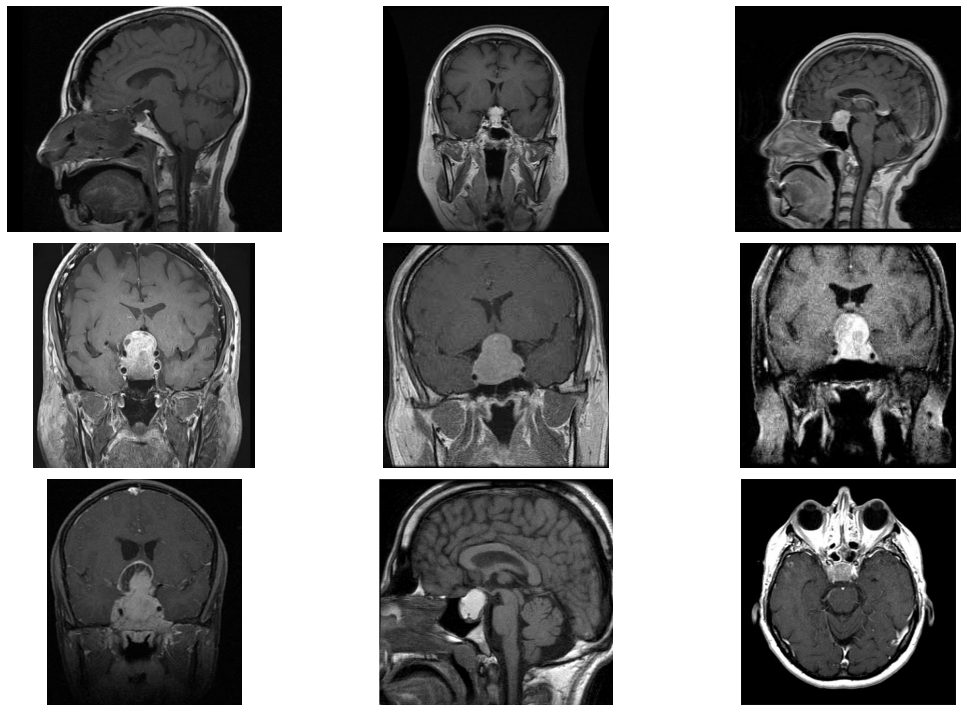

In [11]:
Pituitary_tumor_dir='/content/drive/MyDrive/Deep Db/Testing/pituitary_tumor'
plot_images(Pituitary_tumor_dir)

In [12]:
X_train = []
y_train = []
image_size = 150
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Deep Db/Training',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Deep Db/Testing',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

In [13]:
y_train

array(['glioma_tumor', 'glioma_tumor', 'glioma_tumor', ...,
       'pituitary_tumor', 'pituitary_tumor', 'pituitary_tumor'],
      dtype='<U16')

In [14]:
classes=["glioma_tumor","pituitary_tumor","meningioma tumor","no tumor"]

In [15]:
X_train,y_train=shuffle(X_train,y_train,random_state=1)
X_train.shape

(3264, 150, 150, 3)

In [16]:
X_train,X_test,y_train,y_test=train_test_split(X_train,y_train,test_size=.1,random_state=101)

In [17]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)
y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [18]:
images_dict = dict()
x_train_dict=dict()
for i, l in enumerate(y_train_new):
  if len(images_dict)==4:
    break
  if l not in images_dict.keys():
    x_train_dict[l] = X_train[i]
    images_dict[l] = X_train[i].reshape((150, 150,3))
images_dict = dict(sorted(images_dict.items()))
x_trian_each_class = [x_train_dict[i] for i in sorted(x_train_dict)]
x_train_each_class = np.asarray(x_trian_each_class)
    
# example image for each class for test set
X_test_dict = dict()
for i, l in enumerate(y_test_new):
  if len(X_test_dict)==4:
    break
  if l not in X_test_dict.keys():
    X_test_dict[l] = X_test[i]
# order by class
x_test_each_class = [X_test_dict[i] for i in sorted(X_test_dict)]
x_test_each_class = np.asarray(x_test_each_class)

In [19]:
y_test

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [20]:
def plot_sample(x,y,index):
  plt.figure(figsize=(15,2))
  plt.imshow(x[index])
  plt.xlabel(classes[y[index]])

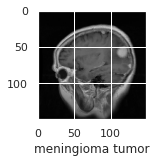

In [38]:

plot_sample(X_train,y_train_new,0)

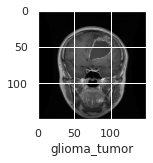

In [39]:
plot_sample(X_train,y_train_new,6)

In [87]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [88]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [89]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 150, 150, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 150, 150, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                            

In [90]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [91]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [92]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
83/83 [==============================] - ETA: 0s - loss: 0.4897 - accuracy: 0.8101
Epoch 1: val_accuracy improved from -inf to 0.78231, saving model to effnet.h5
83/83 [==============================] - 346s 4s/step - loss: 0.4897 - accuracy: 0.8101 - val_loss: 0.6154 - val_accuracy: 0.7823 - lr: 0.0010
Epoch 2/12
83/83 [==============================] - ETA: 0s - loss: 0.1850 - accuracy: 0.9368
Epoch 2: val_accuracy improved from 0.78231 to 0.91497, saving model to effnet.h5
83/83 [==============================] - 331s 4s/step - loss: 0.1850 - accuracy: 0.9368 - val_loss: 0.2515 - val_accuracy: 0.9150 - lr: 0.0010
Epoch 3/12
83/83 [==============================] - ETA: 0s - loss: 0.1128 - accuracy: 0.9633
Epoch 3: val_accuracy improved from 0.91497 to 0.92857, saving model to effnet.h5
83/83 [==============================] - 331s 4s/step - loss: 0.1128 - accuracy: 0.9633 - val_loss: 0.2577 - val_accuracy: 0.9286 - lr: 0.0010
Epoch 4/12
83/83 [============================

predict

In [27]:
Y_pred=model.predict(X_test)

In [28]:
Y_pred[:5]

array([[4.5073239e-06, 9.9997795e-01, 8.6196273e-08, 1.7382512e-05],
       [9.9999905e-01, 7.8293368e-07, 1.3092186e-07, 4.2336900e-08],
       [1.0861670e-05, 1.8861590e-05, 4.4005246e-05, 9.9992621e-01],
       [1.4906817e-06, 3.6516938e-02, 5.4985144e-08, 9.6348155e-01],
       [1.6987377e-06, 1.0431581e-06, 9.2725340e-06, 9.9998796e-01]],
      dtype=float32)

In [29]:
y_class=[np.argmax(x) for x in Y_pred]

In [ ]:
y_class[:5]

[1, 0, 3, 3, 3]

In [ ]:
y_test_new[:5]

[1, 0, 3, 3, 3]

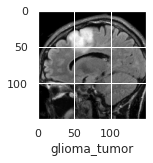

In [41]:
plot_sample(X_test,y_test_new,5)

In [42]:
classes[y_class[5]]

'glioma_tumor'

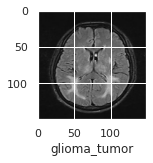

In [43]:
plot_sample(X_train,y_test_new,1)

In [44]:
classes[y_class[1]]

'glioma_tumor'

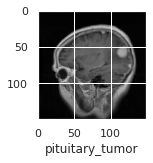

In [45]:
plot_sample(X_train,y_test_new,0)

In [46]:
classes[y_class[0]]

'pituitary_tumor'

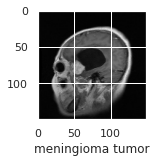

In [47]:
plot_sample(X_train,y_test_new,11 )

In [48]:
classes[y_class[11]]

'meningioma tumor'

Shap

In [33]:
predictions = model.predict(x_test_each_class)
predicted_class = np.argmax(predictions, axis=1)
predicted_class

array([0, 1, 0, 3])

In [ ]:
def plot_actual_predicted(images, pred_classes):
  fig, axes = plt.subplots(1, 4, figsize=(16, 15))
  axes = axes.flatten()
  
  # plot
  ax = axes[0]
  dummy_array = np.array([[[0, 0, 0, 0]]], dtype='uint8')
  ax.set_title("Base reference")
  ax.set_axis_off()
  ax.imshow(dummy_array, interpolation='nearest')
  # plot image
  for k,v in images.items():
    ax = axes[int(k)]
    ax.imshow(v, cmap=plt.cm.binary)
    ax.set_title(f"True: %s \nPredict: %s" % (classes[k], classes[pred_classes[k]]))
    ax.set_axis_off()
  plt.tight_layout()
  plt.show()


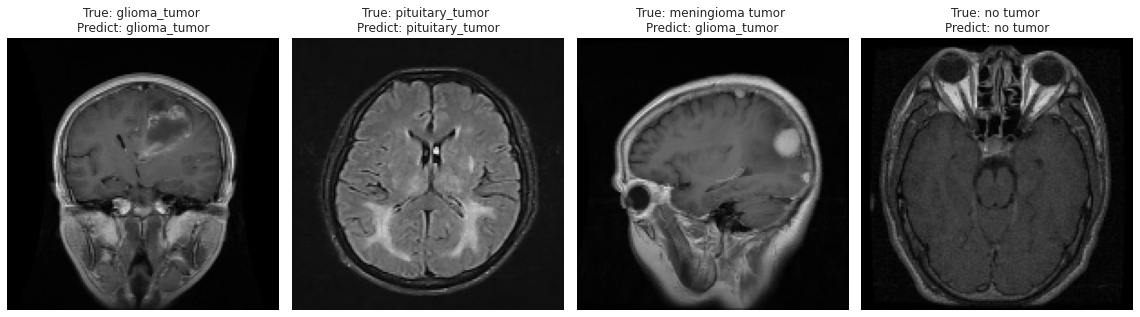

In [40]:
plot_actual_predicted(images_dict, predicted_class)


In [62]:
masker = shap.maskers.Image("inpaint_telea", X_train[0].shape)

explainer = shap.Explainer(model, masker, output_names=classes)

explainer

In [63]:
shap_values = explainer(x_test_each_class, outputs=shap.Explanation.argsort.flip[:5])

shap_values.shape


  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  25%|██▌       | 1/4 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  75%|███████▌  | 3/4 [01:16<00:17, 17.72s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 4/4 [01:50<00:00, 24.19s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 5it [02:24, 36.07s/it]


(4, 150, 150, 3, 4)

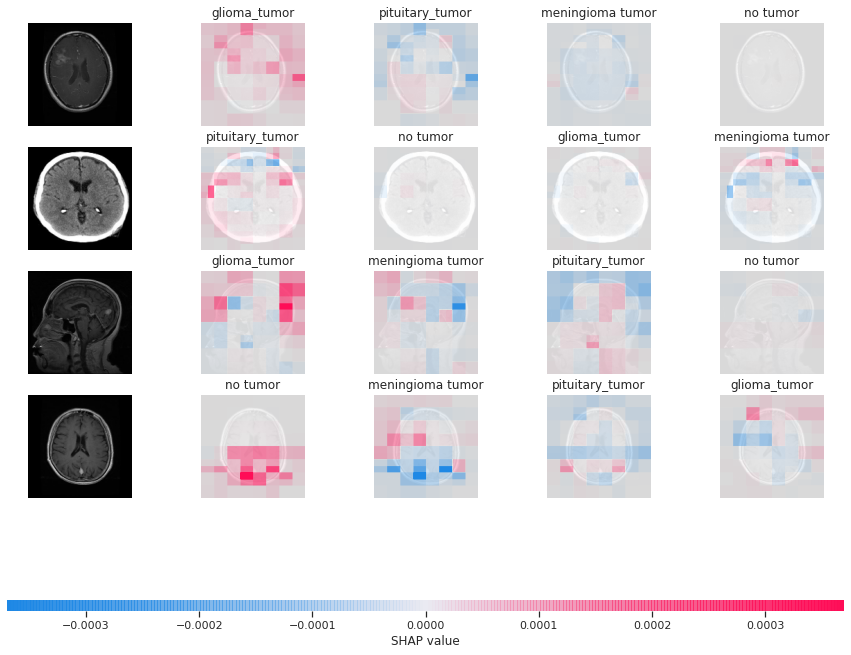

In [64]:
shap.image_plot(shap_values)

Report,Confution Matrix

In [ ]:
print(classification_report(y_test_new,y_class))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96        88
           1       0.98      1.00      0.99        50
           2       0.96      0.96      0.96        96
           3       0.99      0.99      0.99        93

    accuracy                           0.97       327
   macro avg       0.97      0.98      0.97       327
weighted avg       0.97      0.97      0.97       327



In [66]:
cm=tf.math.confusion_matrix(labels=y_test_new,predictions=y_class)
cm

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[82,  1,  5,  0],
       [ 0, 50,  0,  0],
       [ 3,  0, 91,  2],
       [ 0,  0,  1, 92]], dtype=int32)>

Text(66.5, 0.5, 'Truth')

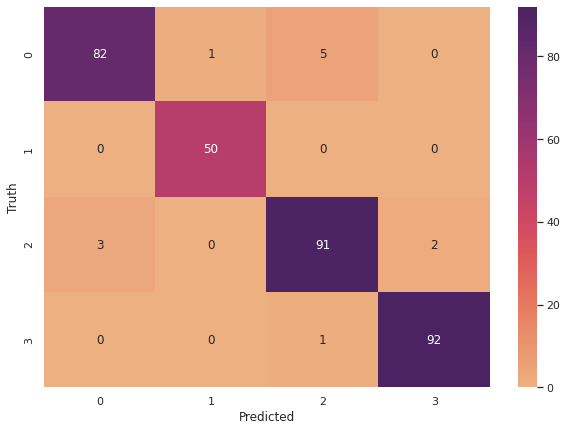

In [67]:
import seaborn as sns
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d',cmap='flare')
plt.xlabel('Predicted')
plt.ylabel('Truth')


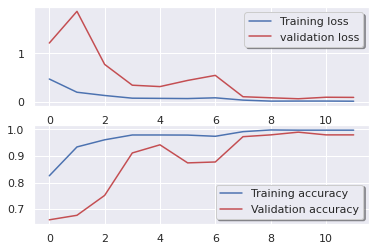

In [68]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

ANN

In [69]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='sigmoid')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [70]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [71]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [72]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
83/83 [==============================] - ETA: 0s - loss: 0.1040 - accuracy: 0.9686
Epoch 1: val_accuracy improved from -inf to 0.91837, saving model to effnet.h5
83/83 [==============================] - 349s 4s/step - loss: 0.1040 - accuracy: 0.9686 - val_loss: 0.5081 - val_accuracy: 0.9184 - lr: 0.0010
Epoch 2/12
83/83 [==============================] - ETA: 0s - loss: 0.0883 - accuracy: 0.9716
Epoch 2: val_accuracy did not improve from 0.91837
83/83 [==============================] - 335s 4s/step - loss: 0.0883 - accuracy: 0.9716 - val_loss: 0.3715 - val_accuracy: 0.9150 - lr: 0.0010
Epoch 3/12
83/83 [==============================] - ETA: 0s - loss: 0.0710 - accuracy: 0.9781
Epoch 3: val_accuracy improved from 0.91837 to 0.94218, saving model to effnet.h5
83/83 [==============================] - 330s 4s/step - loss: 0.0710 - accuracy: 0.9781 - val_loss: 0.2077 - val_accuracy: 0.9422 - lr: 0.0010
Epoch 4/12
83/83 [==============================] - ETA: 0s - loss: 0.0298 - 

predict


In [73]:
Y_pred=model.predict(X_test)


In [74]:
y_class=[np.argmax(x) for x in Y_pred]


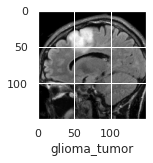

In [75]:
plot_sample(X_test,y_test_new,5)

In [ ]:
classes[y_class[5]]

'glioma_tumor'

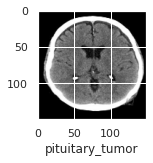

In [ ]:
plot_sample(X_test,y_test_new,0)

Shap

In [76]:
predictions = model.predict(x_test_each_class)
predicted_class = np.argmax(predictions, axis=1)
predicted_class

array([0, 1, 2, 3])

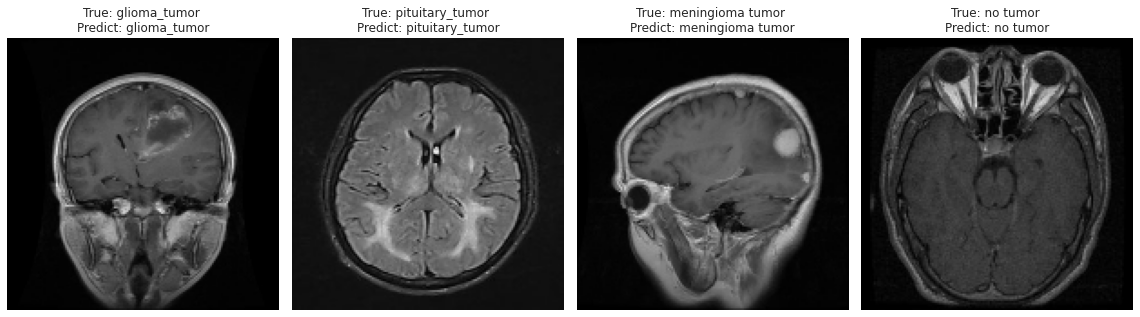

In [77]:
plot_actual_predicted(images_dict, predicted_class)


In [78]:
masker = shap.maskers.Image("inpaint_telea", X_train[0].shape)

explainer = shap.Explainer(model, masker, output_names=classes)

explainer

In [79]:
shap_values = explainer(x_test_each_class, outputs=shap.Explanation.argsort.flip[:5])

shap_values.shape


  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  25%|██▌       | 1/4 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  75%|███████▌  | 3/4 [01:15<00:16, 16.42s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 4/4 [01:47<00:00, 22.86s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 5it [02:19, 34.95s/it]


(4, 150, 150, 3, 4)

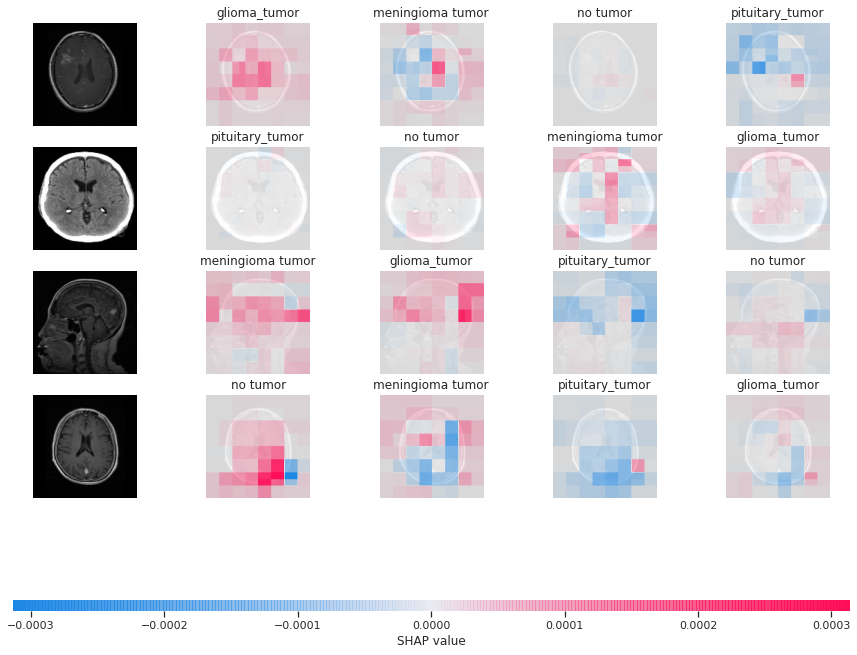

In [80]:
shap.image_plot(shap_values)

In [ ]:
print(classification_report(y_test_new,y_class))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95        88
           1       0.98      1.00      0.99        50
           2       0.95      0.94      0.94        96
           3       0.98      0.99      0.98        93

    accuracy                           0.96       327
   macro avg       0.97      0.97      0.97       327
weighted avg       0.96      0.96      0.96       327



In [ ]:
cm=tf.math.confusion_matrix(labels=y_test_new,predictions=y_class)
cm

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[83,  1,  4,  0],
       [ 0, 50,  0,  0],
       [ 4,  0, 90,  2],
       [ 0,  0,  1, 92]], dtype=int32)>

Text(66.5, 0.5, 'Truth')

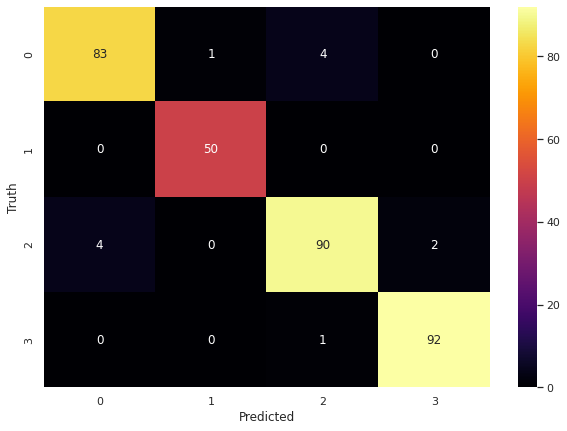

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d',cmap='inferno')
plt.xlabel('Predicted')
plt.ylabel('Truth')


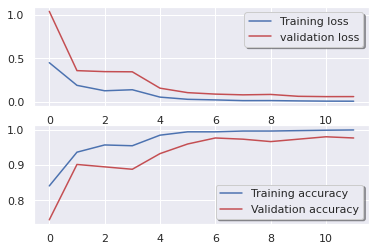

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)